# El Salvador Tree Cover EDA with Rasterio


**Goals**
- Identify the mean tree cover by jurisdiction for the TOF and Hansen data.
- Identify the number of hectares w/ > 10% tree cover for TOF and Hansen data
- Create a .csv with `jursidiction`, `hansen_perc_cover`, `tof_perc_cover`, `hansen_forest_ha`, `tof_forest_ha`

**Long term Goals**
- In the future, we will want to be able to do these analyses by incorporating other datasets, such as ecoregion, land cover, aridity zone, etc. 
- ex: Hansen data shows 17% tree cover for rwanda and TOF data shows 32% tree cover for rwanda versus Hansen data shows 350,000 ha > 10% tree cover and TOF data shows 620,000 ha > 10% tree cover. Then eventually we can compute confidence interval for moist tropical broadleaf forests in central africa 620,000 +/- 25,000

**Useful links**
- https://rasterio.readthedocs.io/en/latest/quickstart.html
- https://rasterio.readthedocs.io/en/latest/topics/masking-by-shapefile.html
- https://www.hatarilabs.com/ih-en/how-to-clip-sentinel-2-bands-to-a-area-of-interest-with-python-rasterio-and-fiona-tutorial

**Data**  
- sentinel_treecover.tif
- hansen_treecover.tif
- *.geojson - subnational jurisdictions


In [1]:
!aws s3 cp s3://restoration-monitoring/restoration-mapper/tifs/ . --recursive

download: s3://restoration-monitoring/restoration-mapper/tifs/elsalvador_adm2.geojson to ./elsalvador_adm2.geojson
download: s3://restoration-monitoring/restoration-mapper/tifs/hansen_treecover.tif to ./hansen_treecover.tif
download: s3://restoration-monitoring/restoration-mapper/tifs/sentinel_treecover.tif to ./sentinel_treecover.tif


# EDA

In [1]:
import os
import rasterio as rs
from rasterio.mask import mask
from rasterio.plot import show, show_hist, adjust_band
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import pyproj
import geopandas as gpd 
import pandas as pd
import fiona
from skimage.transform import resize

%matplotlib inline

## Explore Data

In [12]:
tof_data = rs.open("sentinel_treecover.tif")
tof_data.shape

(6309, 11801)

In [13]:
tof_data.bounds

BoundingBox(left=-90.036167469, bottom=13.417995853, right=-88.953163734, top=13.996986665)

In [14]:
# get the value for a pixel 100 km east and 50km south of the datasets upper left corner
x, y = (tof_data.bounds.left + 100_000, tof_data.bounds.top - 50_000)
row, col = tof_data.index(x, y)
row, col

(544827298, 1089654598)

In [15]:
print(f'Raster description: {tof_data.profile}')

Raster description: {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 11801, 'height': 6309, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(9.177220023726849e-05, 0.0, -90.036167469,
       0.0, -9.177220034870802e-05, 13.996986665), 'tiled': False, 'interleave': 'band'}


In [16]:
# get the coordinates of the center of the image
tof_data.xy(tof_data.height // 2, tof_data.width // 2)

(-89.4946656015, 13.707491259)

In [17]:
# read method returns an np array.
tof_data = tof_data.read(1)

In [18]:
# check band statistics
band_mean = np.mean(tof_data)
band_min = np.min(tof_data)
band_max = np.max(tof_data)
band_std = np.std(tof_data)
print(f'Mean: {band_mean} Range: {band_min} - {band_max} Standard Dev: {band_std}')

Mean: 31.304041869159843 Range: 0 - 99 Standard Dev: 42.364882030375746


In [19]:
# resize to be divisible by 10
tof_data.shape

(6309, 11801)

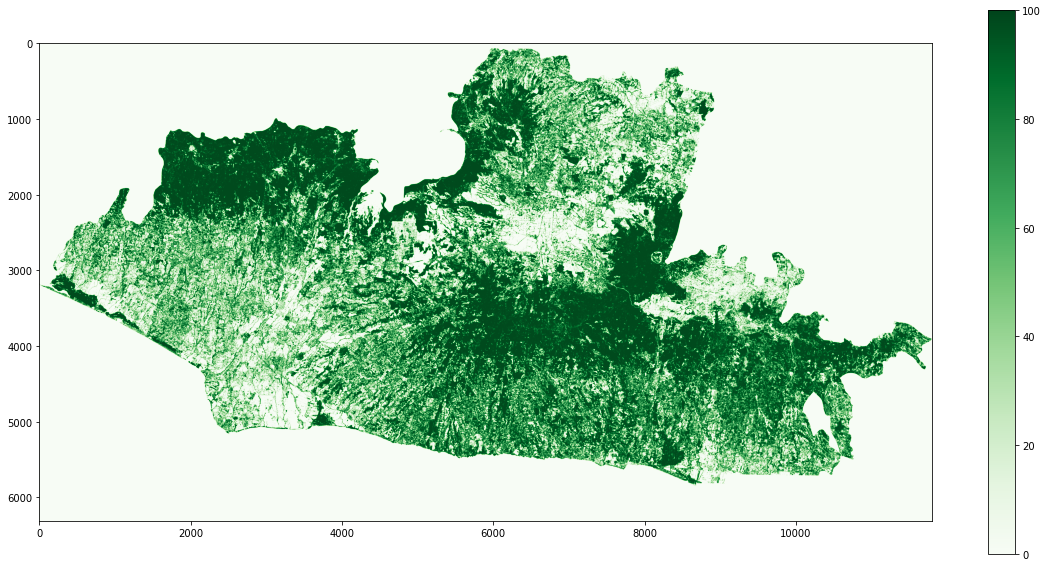

In [20]:
plt.figure(figsize=(20,10))
plt.imshow(tof_data, cmap='Greens', vmin=0, vmax=100)
plt.colorbar()
plt.show()

In [25]:
hansen_data = rs.open("hansen_treecover.tif")
hansen_data = hansen_data.read(1)
print(hansen_data.shape)

(2316, 4331)


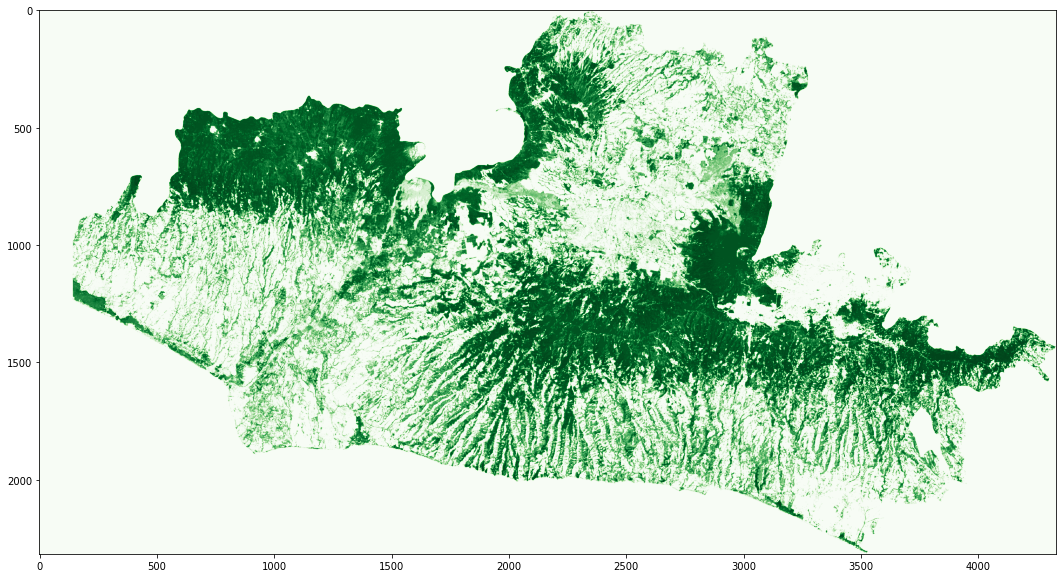

In [26]:
plt.figure(figsize=(20,10))
plt.imshow(hansen_data, cmap='Greens', vmin=0, vmax=100)
plt.show()

In [2]:
# import shapefile
jurisdictions = gpd.read_file('elsalvador_adm2.geojson')

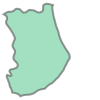

In [24]:
jurisdictions.geometry[0]

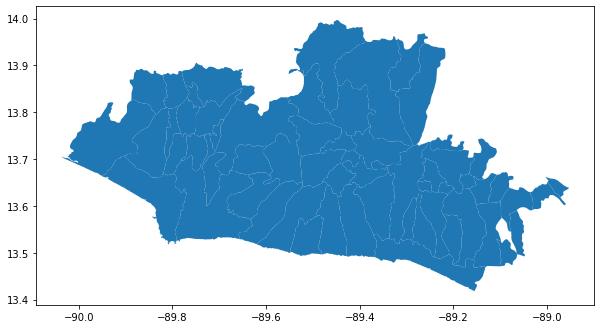

In [70]:
fig, ax = plt.subplots(figsize=(10,10))
jurisdictions.plot(ax=ax);

In [41]:
jurisdictions.head()

,Shape_Leng,Shape_Area,ADM2_ES,ADM2_PCODE,ADM2_REF,ADM2ALT1ES,ADM2ALT2ES,ADM1_ES,ADM1_PCODE,ADM0_ES,ADM0_PCODE,date,validOn,validTo,geometry
0,0.253137,0.003054,Apaneca,SV0102,None,None,None,Ahuachapán,SV01,El Salvador,SV,2020-05-29,2021-02-04,None,"MULTIPOLYGON (((-89.82207 13.87903, -89.82079 ..."
1,0.326220,0.005182,Concepción de Ataco,SV0104,Concepcion de Ataco,None,None,Ahuachapán,SV01,El Salvador,SV,2020-05-29,2021-02-04,None,"MULTIPOLYGON (((-89.81461 13.81050, -89.81467 ..."
2,0.439992,0.007796,Guaymango,SV0106,None,None,None,Ahuachapán,SV01,El Salvador,SV,2020-05-29,2021-02-04,None,"MULTIPOLYGON (((-89.81228 13.69891, -89.81432 ..."
3,0.798428,0.015678,Jujutla,SV0107,None,None,None,Ahuachapán,SV01,El Salvador,SV,2020-05-29,2021-02-04,None,"MULTIPOLYGON (((-89.92748 13.82101, -89.92649 ..."
4,0.281148,0.001747,San Pedro Puxtla,SV0110,None,None,None,Ahuachapán,SV01,El Salvador,SV,2020-05-29,2021-02-04,None,"MULTIPOLYGON (((-89.78200 13.75532, -89.78310 ..."


## Mask Rasters

In [3]:
tof_data = rs.open("sentinel_treecover.tif")
hansen_data = rs.open("hansen_treecover.tif")

In [31]:
def mask_raster(raster, shapefile, data):
    
    '''
    Function takes in a raster file for a country, masks out jurisdictions 
    based on polygons defined in the shapefile and then writes the masked 
    raster to a new file.
    '''
    for geo, juris in zip(shapefile.geometry, shapefile.ADM2_ES):
        
            out_img, out_transform = mask(dataset=raster, shapes=geo, crop=True)
            out_meta = raster.meta
            out_meta.update({'driver': 'GTiff',    
                             'dtype': 'uint8',
                             'height': out_img.shape[1],
                             'width': out_img.shape[2],
                             'transform': out_transform})

            outpath = os.path.join(f'clipped_rasters/{data}', f'{str(juris)}')
            outraster = rs.open(outpath, "w", **out_meta) 
            outraster.write(out_img)
            outraster.close()
           
    return f'{data} rasters clipped and saved.'

In [32]:
mask_raster(tof_data, jurisdictions, 'tof')

'tof rasters clipped and saved.'

In [33]:
mask_raster(hansen_data, jurisdictions, 'hansen')

'hansen rasters clipped and saved.'

## Calculate Tree Cover per Jurisdiction

In [35]:
def hansen_versus_tof(jurisdiction_list, tof, hansen):

    def calculate_tree_cover(jurisdiction, raster, folder_name): 
        
        clipped_raster = rs.open(f'clipped_rasters/{folder_name}/{jurisdiction}').read(1)
        def round_down(num, divisor):
                return num - (num%divisor)
        rows, cols = round_down(clipped_raster.shape[0], 10), round_down(clipped_raster.shape[1], 10)
        rounded = clipped_raster[:rows, :cols]
        reshaped = np.reshape(rounded, (int(rounded.shape[0] / 10), 10, int(rounded.shape[1] / 10), 10))
        mean = round(np.mean(reshaped), 3)
        mean_tc = np.mean(reshaped, axis=(1,3)) # mean tree cover for jurisdiction
        ha_over10 = np.sum(mean_tc > 10)        # num of hectares >10% tree cover
        
        return mean, ha_over10
    
    tree_cover = pd.DataFrame(columns=['jurisdiction', 'tof_mean_tc', 'tof_total_ha',
                                       'hansen_mean_tc', 'hansen_total_ha'])
    
    for i in jurisdiction_list:
        tof_tc, tof_over10 = calculate_tree_cover(i, tof, 'tof')
        hansen_tc, hansen_over10 = calculate_tree_cover(i, hansen, 'hansen')
        tree_cover = tree_cover.append({'jurisdiction': i, 
                                        'tof_mean_tc': tof_tc, 
                                        'tof_total_ha': tof_over10,
                                        'hansen_mean_tc': hansen_tc, 
                                        'hansen_total_ha': hansen_over10}, ignore_index=True)
        
        tree_cover['ha_diff'] = tree_cover['tof_total_ha'] - tree_cover['hansen_total_ha']
    
    return tree_cover

In [40]:
df = hansen_versus_tof(list(jurisdictions.ADM2_ES), tof_data, hansen_data)
df

,jurisdiction,tof_mean_tc,tof_total_ha,hansen_mean_tc,hansen_total_ha,ha_diff
0,Apaneca,61.411,3712,58.011,518,3194
1,Concepción de Ataco,61.418,6281,59.646,875,5406
2,Guaymango,27.645,9031,12.610,882,8149
3,Jujutla,26.606,16974,14.653,1692,15282
4,San Pedro Puxtla,25.477,2058,17.245,234,1824
5,Antiguo Cuscatlán,30.015,2161,26.948,255,1906
6,Chiltiupán,46.115,7387,29.671,913,6474
7,Ciudad Arce,22.827,6264,10.681,643,5621
8,Colón,30.900,6183,28.668,840,5343
9,Comasagua,47.078,8831,34.212,1119,7712


In [93]:
# save to csv
df.to_csv('tree-cover-el-salvador.csv', index=False)

## Visual Comparisons

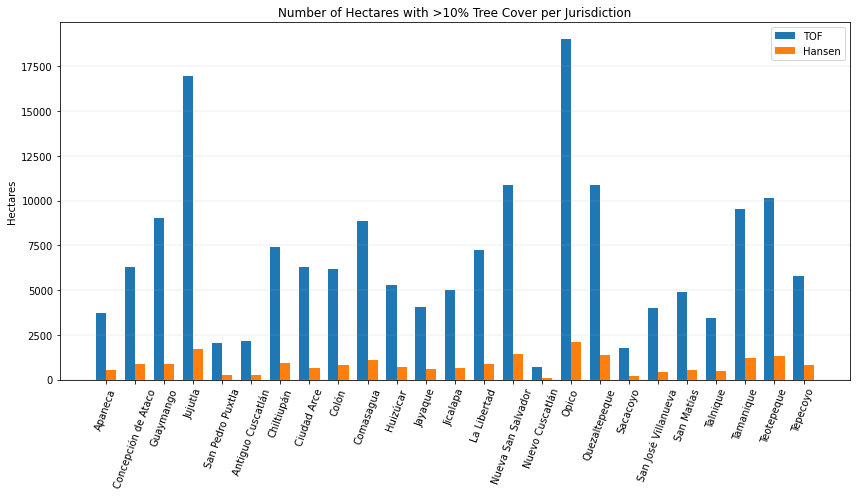

In [118]:
labels = list(df.jurisdiction)[:25]
x = np.arange(len(labels))  
width = 0.35  # the width of the bars

plt.figure(figsize=(12,7))
plt.bar(x - width/2, df.tof_total_ha[:25], width, label='TOF')
plt.bar(x + width/2, df.hansen_total_ha[:25], width, label='Hansen')

plt.ylabel('Hectares')
plt.title('Number of Hectares with >10% Tree Cover per Jurisdiction')
plt.xticks(x, labels=labels, rotation=70)
plt.legend()
plt.grid(axis='y', linewidth=.2)

plt.tight_layout();

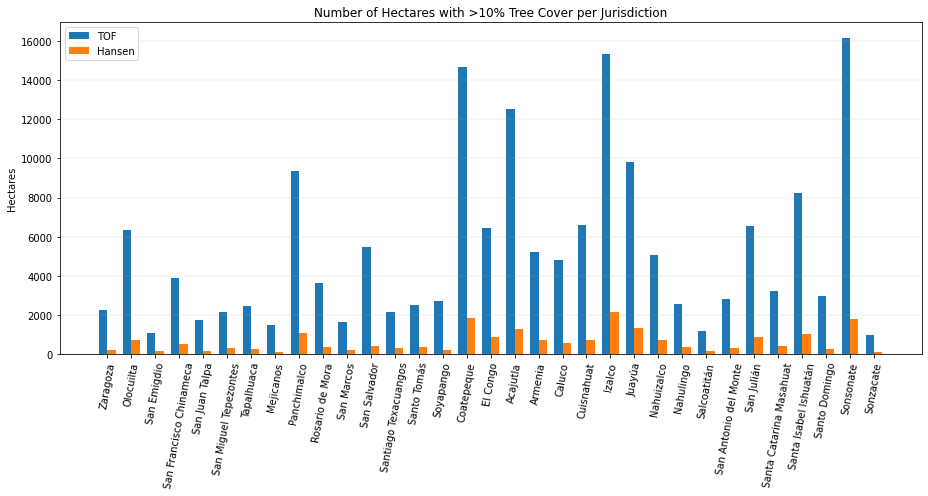

In [117]:
labels = list(df.jurisdiction)[25:]
x = np.arange(len(labels))  
width = 0.35  # the width of the bars

plt.figure(figsize=(13,7))
plt.bar(x - width/2, df.tof_total_ha[25:], width, label='TOF')
plt.bar(x + width/2, df.hansen_total_ha[25:], width, label='Hansen')

plt.ylabel('Hectares')
plt.title('Number of Hectares with >10% Tree Cover per Jurisdiction')
plt.xticks(x, labels=labels, rotation=80)
plt.legend()
plt.grid(axis='y', linewidth=.2)

plt.tight_layout();

In [81]:
# where is the biggest discrepency between TOF/Hansen?
df.sort_values(by='ha_diff', ascending=False)[:10]

,jurisdiction,tof_mean_tc,tof_total_ha,hansen_mean_tc,hansen_total_ha,ha_diff
16,Opico,23.850,18996,14.075,2077,16919
3,Jujutla,26.606,16974,14.653,1692,15282
56,Sonsonate,16.146,16138,8.881,1818,14320
46,Izalco,29.280,15315,25.226,2147,13168
40,Coatepeque,28.520,14673,21.602,1839,12834
42,Acajutla,14.289,12509,8.372,1277,11232
17,Quezaltepeque,25.719,10849,19.950,1404,9445
14,Nueva San Salvador,28.830,10850,23.305,1418,9432
23,Teotepeque,28.542,10153,20.838,1295,8858
47,Juayúa,51.107,9832,47.920,1365,8467


In [82]:
opico_tof = rs.open('clipped_rasters/tof/Opico').read(1)
opico_han = rs.open('clipped_rasters/hansen/Opico').read(1)
opico_tof.shape, opico_han.shape

((2561, 1848), (941, 679))

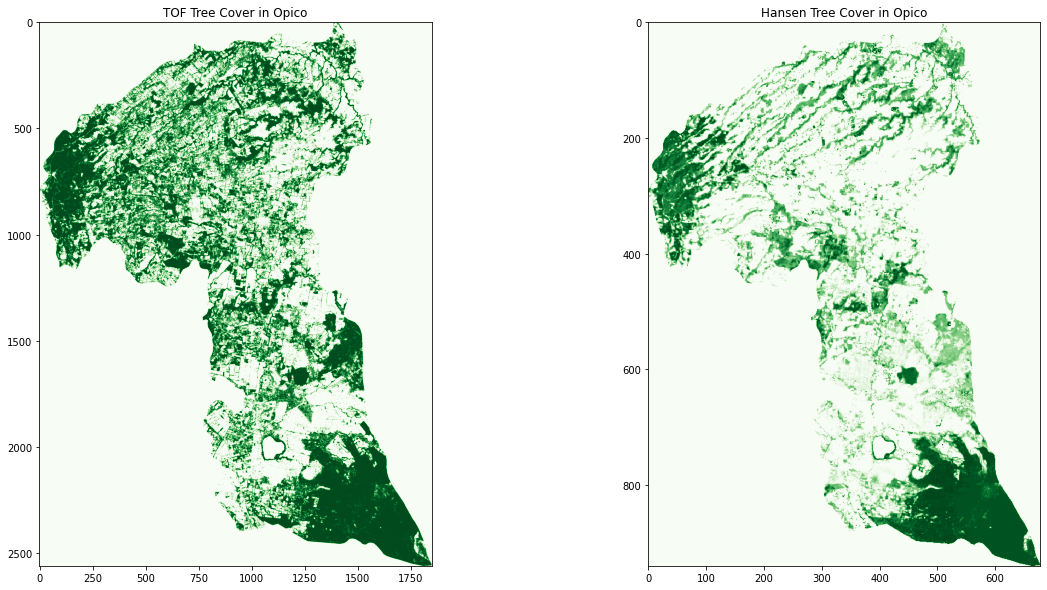

In [103]:
# Visualize tree cover difference for specific jurisdiction

plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.imshow(opico_tof, cmap='Greens', vmin=0, vmax=100)
plt.title('TOF Tree Cover in Opico')

plt.subplot(1,2,2)
plt.imshow(opico_han, cmap='Greens', vmin=0, vmax=100)
plt.title('Hansen Tree Cover in Opico')


plt.tight_layout;

### Old

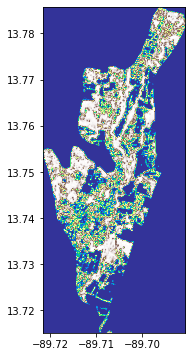

In [101]:
# test one of the clipped files
apaneca_clipped = rs.open('clipped_rasters/Apaneca')

fig, ax = plt.subplots(figsize=(10,6))
show((clipped, 1), cmap='terrain');